# **Classification of Images in Yale & KDEF Databases** 

## **Foreword**

### **Introduction & Citation**

As a source of images two different databases utilized;

1. The original dataset of Yale faces containing 165 grayscale images of 15 individuals. More metadata can be found here: http://vision.ucsd.edu/datasetsAll

2. Karolinska Directed Emotional Faces (KDEF) where nearly 500 pictures and annotated target emotions. More metadata can be found here: https://www.ugent.be/pp/ekgp/en/research/research-groups/panlab/kdef


---


The mathematical conversion of the face landmarks are inspired from the hint website: http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/

While I got inspired about the implementations from other sources as well, all of the following code is written by myself and no copy code is used. Excluding the following snipped which is directly reused from the hint website;

```
      for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
        landmarks_vectorised.append(w)
        landmarks_vectorised.append(z)
        meannp = np.asarray((ymean,xmean))
        coornp = np.asarray((z,w))
        dist = np.linalg.norm(coornp-meannp)
        landmarks_vectorised.append(dist)
        landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
```





### **How to use this notebook?**

This notebook is designed to be a sequential run. Skipping some cells may cause a fail. The total sequential run time is about 15 minutes. Please run the cell blocks sequentially up until **classification models** header. After this point, the run order can be personalized. 


### **A word on classification metrics**

Under the **classification report function**, there are many different evaluation metrics reported. Unfortunately, there is no metric to rule them all. Yet, we can argue that Matthews Correlation Coefficient (MCC) is a good option given the context. For multi-class implementation, please see https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0041882

For a detailed discussion on why it is a better choice than f1 and accuracy, please see https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7

Although we will use the MCC to decide which classifier outperforms others, the final model will be reported with a full classification report. Since other statistics are useful to interpret the results and even compare. 

### **Benchmark: Another study with KDEF dataset**

Please see the following paper from Stanford University using deep learning techniques and SVM: http://cs231n.stanford.edu/reports/2017/pdfs/224.pdf

The SVM accuracy reported 0.379 and the highest accuracy reported as 0.758 with the ensemble model. Since they did not report MCC, we cannot compare it with the metric of our initial choice. 

---


*Our models reached an accuracy of 0.734 with naive test/train split with SVM and 0.723 mean accuracy with 10 fold cross-validation.*



### **Limitations & Possible improvements**

1. The random split function use a shuffle from the random library, there is no seed set for this operation. This implies that with every run, similar but variant results are expected.
2. Hyperparameter search and optimization is not performed. The models tried with *sensible* options. There is still room to increase MCC by parameter optimization.
3. Only a single algorithm to translate landmarks to mathematical arrays used (inspired from the hint website). There could be other transformations such as polygons from landmarks or different distances such as Mahalanobis distance can be used to improve the input.
4. Deep learning methods are left out of scope. It is well-known that combining feature extraction and classification tasks with neural networks such as CNN usually outperforms the split tasks as this one. One can consider these models for improvement.  
5. Yale faces dataset has a second extensive edition over one GB, it could be used to improve training.
6. Some faces could not be detected from KDEF dataset. This is behaviour is due to the close up pictures. One can apply padding in all edges before detecting faces which can increase the face detections. 


## **Import Libraries & Test Initial Data** 

In [ ]:
# Install & Import libraries 

## Computer vision & Image Processing

import cv2
import dlib
from PIL import Image
from google.colab.patches import cv2_imshow

## Machine Learning

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# Cross validation

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Classification Metrics

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

## Miscellaneous

from IPython.display import clear_output
import pandas as pd
import glob
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

## Build dlib landmarks

!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2
datFile =  "/content/shape_predictor_68_face_landmarks.dat"

clear_output(wait=True)
print('All imports & builds are successfully completed!')

All imports & builds are successfully completed!


In [ ]:
# Download & Unzip datasets

## Yale faces (first edition)
try:
  !wget http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip
  !unzip yalefaces.zip
  clear_output(wait=True)
  print('Yale faces dataset downloaded & unzipped successfully!')
except:
  print('Error occured while downloading Yale faces dataset!')

Yale faces dataset downloaded & unzipped successfully!


In [ ]:
# Download & Unzip datasets

## Karolinska Directed Emotional Faces (KDEF)
try:
  !wget https://www.ugent.be/pp/ekgp/en/research/research-groups/panlab/kdef/pictures.zip
  !wget https://www.ugent.be/pp/ekgp/en/research/research-groups/panlab/kdef/dataset.xls
  !unzip pictures.zip
  !mv 'KDEF (reeks A) zonder haarlijn' kdeffaces
  clear_output(wait=True)
  print('KDEF dataset downloaded & unzipped successfully!')
except:
  print('Error occured while downloading Yale faces dataset!')

KDEF dataset downloaded & unzipped successfully!


In [ ]:
# Parse the KDEF target outcomes

kdef_frame = pd.read_excel("dataset.xls")
kdef_frame = kdef_frame[["KDEF code", "Target emotion"]]
kdef_frame.head()

,KDEF code,Target emotion
0,M11AF,Fearful
1,M25AF,Fearful
2,M14AF,Fearful
3,M17AF,Fearful
4,M19AF,Fearful


Text(0.5, 1.0, 'Yale: Subject 01 (Normal)')

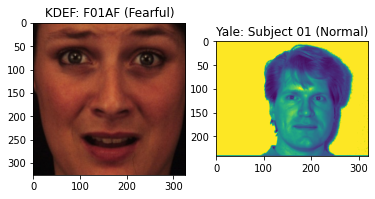

In [ ]:
## Open random image from datasets

kdef_r1 = Image.open("kdeffaces/F01AF.jpg")
yale_r1 = Image.open("yalefaces/subject01.gif")

fig, ax = plt.subplots(1,2)
ax[0].imshow(kdef_r1)
ax[0].set_title('KDEF: F01AF (Fearful)')
ax[1].imshow(yale_r1)
ax[1].set_title('Yale: Subject 01 (Normal)')

## **Functions**

In [ ]:
# Functions 

## Get training & testing image locations

### Yale dataset
# - The file names contain valuable information regarding the state of the emotion.
# - We need to extract this information as our target outcome (predictor labels).
# - This function returns training images and test images in order. 

def get_yale_files(image_folder, emotion_codes, training_size): 
    image_set = glob.glob(image_folder)
    final_image_set = []
    for f in image_set:
      emotion_sub = f[f.rindex('.')+1:]
      if (emotion_sub in emotion_codes):
        final_image_set.append(f)
    random.shuffle(final_image_set)
    training_coef = int(len(final_image_set)*training_size)
    return final_image_set[:training_coef], final_image_set[training_coef:]

### KDEF dataset
# - The emotional states are stored in a separate dataframe, the names are arbitrary.
# - This will shorten the function to get training and testing images.
# - This function returns training images and test images in order.

def get_kdef_files(image_folder, training_size): 
    image_set = glob.glob(image_folder)
    random.shuffle(image_set)
    training_coef = int(len(image_set)*training_size)
    return image_set[:training_coef], image_set[training_coef:]

## Extract face features

### Assign detector & face landmark choice

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_face_landmarks(input_image):
  
  # - Yale faces use gif format so that cv2 VideoCapture is used to get embed.
  capture = cv2.VideoCapture(input_image)
  bool_op, image = capture.read()
  capture.release()

  # - If successfully captured the image then process further.
  # - KDEF faces are in gray scale already, yet favor inclusuve function.
  # - All Images should contain only a single face otherwise, no match with outcome/

  if bool_op:
    gray = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if (len(faces) != 1):
      print('Face could not be detected: ', input_image)
      return None
    else:
      xlist = []
      ylist = []
      landmarks = predictor(image=gray, box=faces[0])

      # - Get the face landmark x, y coordinates from landmark 0 to 68
      for n in range(1, 68):
        xlist.append(float(landmarks.part(n).x))
        ylist.append(float(landmarks.part(n).y))

      # - Get the mean values of the x and y coordinates to find the face centroid
      xmean = np.mean(xlist)
      ymean = np.mean(ylist)

      # - Form a new array that computes the distance from the centroid x||y.
      xcentral = [(x-xmean) for x in xlist] 
      ycentral = [(y-ymean) for y in ylist]

      landmarks_vectorised = []
      for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
        landmarks_vectorised.append(w)
        landmarks_vectorised.append(z)
        meannp = np.asarray((ymean,xmean))
        coornp = np.asarray((z,w))
        dist = np.linalg.norm(coornp-meannp)
        landmarks_vectorised.append(dist)
        landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
      return landmarks_vectorised

## Create train_X, train_y, test_X, tesy_y from landmarks

### Yale dataset
# - The target outcomes assigned from the filenames directly.
# - Returns training predictiors, train outcomes, test predictors, tesy outcome in order.
def get_yale_train_test(training_files, prediction_files, yale_emotions):
    yale_outcome_codes = list(range(1, len(yale_emotions)+1))
    encoding_dict = dict(zip(yale_emotions, yale_outcome_codes))
    train_X = []
    train_y = []
    for t in training_files:
      train_X.append(get_face_landmarks(t))
      train_y.append(encoding_dict[t[t.rindex('.')+1:]])
    test_X = []
    tesy_y = []
    for p in prediction_files:
      test_X.append(get_face_landmarks(p))
      tesy_y.append(encoding_dict[p[p.rindex('.')+1:]])
    return train_X, train_y, test_X, tesy_y

### KDEF dataset
# - The target outcomes are extracted from the given dataframe.
# - Returns training predictiors, train outcomes, test predictors, tesy outcome in order.
def get_kdef_train_test(training_files, prediction_files, df):
    df["KDEF code"] = df["KDEF code"].apply(lambda x: x.strip())
    values = df["Target emotion"].unique()
    keys = list(range(1, len(values)+1))
    encoding_dict = dict(zip(values,keys))
    train_X = []
    train_y = []
    for t in training_files:
      try:
        t_prefix = t[t.rindex('/')+1:t.rindex('.')]
        training_df_index = df[df["KDEF code"] == t_prefix].index[0]
        if (get_face_landmarks(t) is not None):
          train_X.append(get_face_landmarks(t))
          train_y.append(encoding_dict[df["Target emotion"][training_df_index]])
      except:
        print('Following file could not be parsed: ', t)
        pass
    test_X = []
    tesy_y = []
    for p in prediction_files:
      try:
        p_prefix = p[p.rindex('/')+1:p.rindex('.')]
        prediction_df_index = df[df["KDEF code"] == p_prefix].index[0]
        if (get_face_landmarks(p) is not None):
          test_X.append(get_face_landmarks(p))
          tesy_y.append(encoding_dict[df["Target emotion"][prediction_df_index]])
      except:
        print('Following file could not be parsed: ', p)
        pass
    return train_X, train_y, test_X, tesy_y

##Classification functions
# - Naive classification use train and test split and fit only once.
# - Cross validation use kfold technique (10-fold).
# - Both functions can be used with all ski-learn classifiers.
def naive_classification(model, train_x, train_y, test_x, test_y, emotion_coding):
  model.fit(np.array(train_x), np.array(train_y))
  pred_train = model.predict(np.array(train_x))
  pred_test = model.predict(np.array(test_x))
  naive_classification_metrics(np.array(train_y), np.array(pred_train), np.array(test_y), np.array(pred_test), emotion_coding)

def naive_classification_metrics(train_true, train_pred, test_true, test_pred, emotion_coding):
    print('Training accuracy score: '.ljust(30), accuracy_score(train_true, train_true))
    print('Test accuracy score: '.ljust(30), accuracy_score(test_true, test_pred) )
    print('Test MCC score: '.ljust(30), matthews_corrcoef(test_true, test_pred), '\n')
    print('Test Classification Report: \n')
    print(classification_report(test_true, test_pred, target_names = emotion_coding))

def cv_classification(model, train_x, train_y, test_x, test_y, emotion_coding):
  X = np.array(train_x + test_x)
  y = np.array(train_y + test_y)
  cv = KFold(n_splits=10, random_state=22494, shuffle=True)
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=1)
  pred_all = cross_val_predict(model, X, y, cv=cv)
  print('CV accuracy (mean): '.ljust(30), np.mean(scores))
  print('CV accuracy (std. dev.): '.ljust(30), np.std(scores))
  print('CV predict MCC score: '.ljust(30), matthews_corrcoef(y, pred_all), '\n')
  print('CV Classification Report: \n')
  print(classification_report(y, pred_all, target_names = emotion_coding))

## **Preprocess Phase**

In [ ]:
# Get tranining / testing images

yale_emotions = ['happy','normal','sad','sleepy']
yale_train, yale_test = get_yale_files('/content/yalefaces/*', yale_emotions, 0.8)
kdef_train, kdef_test = get_kdef_files('/content/kdeffaces/*jpg', 0.8)

In [ ]:
# Extract features and form train & test predictor/outcome sets

yale_train_X, yale_train_y, yale_test_X, yale_test_y = get_yale_train_test(yale_train, yale_test, yale_emotions) 
kdef_train_X, kdef_train_y, kdef_test_X, kdef_test_y = get_kdef_train_test(kdef_train, kdef_test, kdef_frame)

Face could not be detected:  /content/kdeffaces/M33SU.jpg
Face could not be detected:  /content/kdeffaces/M34AF.jpg
Face could not be detected:  /content/kdeffaces/M27SU.jpg
Face could not be detected:  /content/kdeffaces/M03SA.jpg
Face could not be detected:  /content/kdeffaces/F27DI.jpg
Face could not be detected:  /content/kdeffaces/F30DI.jpg
Face could not be detected:  /content/kdeffaces/M14AF.jpg
Face could not be detected:  /content/kdeffaces/F25SA.jpg
Face could not be detected:  /content/kdeffaces/F06DI.jpg
Face could not be detected:  /content/kdeffaces/F21SU.jpg
Face could not be detected:  /content/kdeffaces/M34SU.jpg
Face could not be detected:  /content/kdeffaces/M25SU.jpg
Face could not be detected:  /content/kdeffaces/M20SA.jpg
Face could not be detected:  /content/kdeffaces/M16AN.jpg
Face could not be detected:  /content/kdeffaces/F05SA.jpg
Face could not be detected:  /content/kdeffaces/M33SA.jpg
Face could not be detected:  /content/kdeffaces/F26DI.jpg
Face could not

## **Classification Models**

### **Define models**

In [ ]:
model_dict = {'SVC-Linear': SVC(kernel='linear', tol=1e-5),
              'SVC-Polynomial': SVC(kernel='poly', degree=2, tol=1e-5, class_weight='balanced'),
              'KNN': KNeighborsClassifier(n_neighbors=5),
              'OVR(SVC(Linear))': OneVsRestClassifier(SVC(kernel='linear', tol=1e-5)),
              'XGBoost': XGBClassifier(n_estimators=500, random_state=22494)}

#Following models found to be most useful after testing the previous dictionary of models

model_dict_voting = {'SVC-Linear': SVC(kernel='linear', tol=1e-5),
                     'XGBoost': XGBClassifier(n_estimators=500, random_state=22494),
                     'OVR(SVC(Linear))': OneVsRestClassifier(SVC(kernel='linear', tol=1e-5))}

### **Naive models: Yale faces**

In [ ]:
for k,v in model_dict.items():
  print('Model: ', k, '\n')
  naive_classification(v, yale_train_X, yale_train_y, yale_test_X, yale_test_y, yale_emotions)
  print('*'*70, '\n')

Model:  SVC-Linear 

Training accuracy score:       1.0
Test accuracy score:           0.5
Test MCC score:                0.3431372549019608 

Test Classification Report: 

              precision    recall  f1-score   support

       happy       0.67      1.00      0.80         2
      normal       0.50      0.40      0.44         5
         sad       0.25      0.50      0.33         2
      sleepy       1.00      0.33      0.50         3

    accuracy                           0.50        12
   macro avg       0.60      0.56      0.52        12
weighted avg       0.61      0.50      0.50        12

********************************************************************** 

Model:  SVC-Polynomial 

Training accuracy score:       1.0
Test accuracy score:           0.08333333333333333
Test MCC score:                -0.2191785018798023 

Test Classification Report: 

              precision    recall  f1-score   support

       happy       0.00      0.00      0.00         2
      normal    

### **Cross validation models: Yale faces**

In [ ]:
for k,v in model_dict.items():
  print('Model: ', k, '\n')
  cv_classification(v, yale_train_X, yale_train_y, yale_test_X, yale_test_y, yale_emotions)
  print('*'*70, '\n')

Model:  SVC-Linear 

CV accuracy (mean):            0.5333333333333334
CV accuracy (std. dev.):       0.12472191289246469
CV predict MCC score:          0.37819823175073325 

CV Classification Report: 

              precision    recall  f1-score   support

       happy       0.93      0.87      0.90        15
      normal       0.24      0.27      0.25        15
         sad       0.33      0.33      0.33        15
      sleepy       0.71      0.67      0.69        15

    accuracy                           0.53        60
   macro avg       0.55      0.53      0.54        60
weighted avg       0.55      0.53      0.54        60

********************************************************************** 

Model:  SVC-Polynomial 

CV accuracy (mean):            0.16666666666666669
CV accuracy (std. dev.):       0.12909944487358058
CV predict MCC score:          -0.11240923106537389 

CV Classification Report: 

              precision    recall  f1-score   support

       happy       0.16  

### **Voting model: Yale faces**

In [ ]:
estimator_list = []
for k,v in model_dict.items():
  estimator_list.append((k,v))
eclf = VotingClassifier(estimator_list,voting='hard')
cv_classification(eclf, yale_train_X, yale_train_y, yale_test_X, yale_test_y, yale_emotions)

CV accuracy (mean):            0.5166666666666667
CV accuracy (std. dev.):       0.21666666666666665
CV predict MCC score:          0.36415399573275675 

CV Classification Report: 

              precision    recall  f1-score   support

       happy       0.79      1.00      0.88        15
      normal       0.27      0.40      0.32        15
         sad       0.22      0.13      0.17        15
      sleepy       0.80      0.53      0.64        15

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.50        60
weighted avg       0.52      0.52      0.50        60



### **Naive models: KDEF faces**


In [ ]:
for k,v in model_dict.items():
  print('Model: ', k, '\n')
  naive_classification(v, kdef_train_X, kdef_train_y, kdef_test_X, kdef_test_y, kdef_frame["Target emotion"].unique())
  print('*'*70, '\n')

Model:  SVC-Linear 

Training accuracy score:       1.0
Test accuracy score:           0.7340425531914894
Test MCC score:                0.6879167675939143 

Test Classification Report: 

              precision    recall  f1-score   support

     Fearful       0.46      0.55      0.50        11
   Surprised       0.84      0.89      0.86        18
       Angry       0.71      0.75      0.73        16
     Neutral       0.77      0.71      0.74        14
         Sad       0.58      0.54      0.56        13
   Disgusted       0.78      0.70      0.74        10
       Happy       1.00      0.92      0.96        12

    accuracy                           0.73        94
   macro avg       0.73      0.72      0.73        94
weighted avg       0.74      0.73      0.74        94

********************************************************************** 

Model:  SVC-Polynomial 

Training accuracy score:       1.0
Test accuracy score:           0.3723404255319149
Test MCC score:                0

### **Cross validation models: KDEF faces**

In [ ]:
for k,v in model_dict.items():
  print('Model: ', k, '\n')
  cv_classification(v, kdef_train_X, kdef_train_y, kdef_test_X, kdef_test_y, kdef_frame["Target emotion"].unique())
  print('*'*70, '\n')

Model:  SVC-Linear 

CV accuracy (mean):            0.7169750231267346
CV accuracy (std. dev.):       0.06236279943804054
CV predict MCC score:          0.6704029398391255 

CV Classification Report: 

              precision    recall  f1-score   support

     Fearful       0.46      0.55      0.50        64
   Surprised       0.72      0.75      0.73        64
       Angry       0.70      0.74      0.72        68
     Neutral       0.78      0.80      0.79        70
         Sad       0.66      0.59      0.62        63
   Disgusted       0.80      0.68      0.73        65
       Happy       0.94      0.90      0.92        69

    accuracy                           0.72       463
   macro avg       0.72      0.71      0.72       463
weighted avg       0.73      0.72      0.72       463

********************************************************************** 

Model:  SVC-Polynomial 

CV accuracy (mean):            0.4403330249768733
CV accuracy (std. dev.):       0.07471846715167876
CV

### **Voting model: KDEF faces**

In [ ]:
estimator_list = []
for k,v in model_dict.items():
  estimator_list.append((k,v))
eclf = VotingClassifier(estimator_list,voting='hard')
cv_classification(eclf, kdef_train_X, kdef_train_y, kdef_test_X, kdef_test_y, df["Target emotion"].unique())

CV accuracy (mean):            0.6868177613320999
CV accuracy (std. dev.):       0.06456044888979118
CV predict MCC score:          0.6372416613909999 

CV Classification Report: 

              precision    recall  f1-score   support

     Fearful       0.46      0.62      0.53        64
   Surprised       0.72      0.66      0.69        64
       Angry       0.65      0.79      0.72        68
     Neutral       0.71      0.81      0.76        70
         Sad       0.60      0.46      0.52        63
   Disgusted       0.79      0.51      0.62        65
       Happy       0.97      0.91      0.94        69

    accuracy                           0.69       463
   macro avg       0.70      0.68      0.68       463
weighted avg       0.70      0.69      0.69       463



## **Best Model Metrics**

Although full classification reports are accessible under the classification model cells, it is better to print the best models clearly. As mentioned in the foreword, we will use MCC to determine the best classifier.

### **Yale Faces**


---

One vs Rest multiclass strategy combined with Linear SVM

In [ ]:
cv_classification(OneVsRestClassifier(SVC(kernel='linear', tol=1e-5)), yale_train_X, yale_train_y, yale_test_X, yale_test_y, yale_emotions)

CV accuracy (mean):            0.5833333333333334
CV accuracy (std. dev.):       0.15365907428821476
CV predict MCC score:          0.44493909617733324 

CV Classification Report: 

              precision    recall  f1-score   support

       happy       0.93      0.87      0.90        15
      normal       0.29      0.27      0.28        15
         sad       0.35      0.40      0.38        15
      sleepy       0.80      0.80      0.80        15

    accuracy                           0.58        60
   macro avg       0.59      0.58      0.59        60
weighted avg       0.59      0.58      0.59        60



### **KDEF Faces**


---

XGBoost

In [ ]:
cv_classification(XGBClassifier(n_estimators=500, random_state=22494), kdef_train_X, kdef_train_y, kdef_test_X, kdef_test_y, kdef_frame["Target emotion"].unique())

CV accuracy (mean):            0.7235892691951897
CV accuracy (std. dev.):       0.056614775108929476
CV predict MCC score:          0.6779884932654666 

CV Classification Report: 

              precision    recall  f1-score   support

     Fearful       0.58      0.45      0.51        64
   Surprised       0.74      0.75      0.74        64
       Angry       0.71      0.74      0.72        68
     Neutral       0.74      0.84      0.79        70
         Sad       0.64      0.67      0.65        63
   Disgusted       0.74      0.65      0.69        65
       Happy       0.87      0.94      0.90        69

    accuracy                           0.72       463
   macro avg       0.72      0.72      0.72       463
weighted avg       0.72      0.72      0.72       463



## **Print Predicted Probabilities** 

### **Random Yale Face**

happy   :   0.043
normal  :   0.166
sad     :   0.196
sleepy  :   0.595

*** True label is sleepy ***



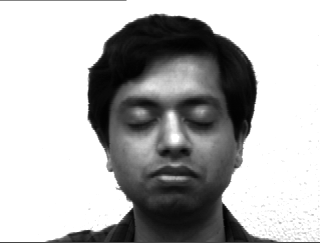

In [ ]:
#Print the predicted probaiblities for each emotional state and the image
# - Change the random seed to get new random image and respective probabilities 

random.seed(22494)
random_image_index = random.randint(0, len(yale_train_X+yale_test_X))

model = OneVsRestClassifier(SVC(kernel='linear', tol=1e-5, probability=True))
model.fit(yale_train_X+yale_test_X, yale_train_y+yale_test_y)
probability_list = model.predict_proba(yale_train_X+yale_test_X)[random_image_index]

for i in range(len(probability_list)):
  print(yale_emotions[i].ljust(7), ":".ljust(3), round(probability_list[i],3))

merged_list = yale_train+yale_test
print('\n*** True label is', merged_list[random_image_index][merged_list[random_image_index].rindex('.')+1:] + ' ***\n')
Image.open(merged_list[random_image_index])

### **Random KDEF Face**

Fearful   :   0.984
Surprised :   0.0
Angry     :   0.001
Neutral   :   0.008
Sad       :   0.008
Disgusted :   0.0
Happy     :   0.0

*** True label is Fearful ***



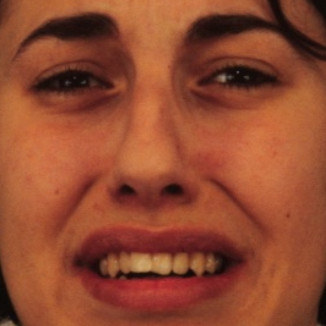

In [ ]:
#Print the predicted probaiblities for each emotional state and the image
# - Change the random seed to get new random image and respective probabilities 

random.seed(22494)
random_image_index = random.randint(0, len(kdef_train_X+kdef_test_X))

model = XGBClassifier(n_estimators=500, random_state=22494)
model.fit(np.array(kdef_train_X+kdef_test_X), np.array(kdef_train_y+kdef_test_y))
probability_list = model.predict_proba(kdef_train_X+kdef_test_X)[random_image_index]

values = kdef_frame["Target emotion"].unique()
for i in range(len(probability_list)):
  print(values[i].ljust(9), ":".ljust(3), round(probability_list[i],3))

merged_list = kdef_train+kdef_test
prefix = merged_list[random_image_index][merged_list[random_image_index].rindex('/')+1:merged_list[random_image_index].rindex('.')]
df_index = kdef_frame[kdef_frame["KDEF code"] == prefix].index[0]
print('\n*** True label is', kdef_frame["Target emotion"][df_index] + ' ***\n')
Image.open(merged_list[random_image_index])